# Data Pre-processing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import glob

### Load data

In [3]:
# Read in data
all_files = glob.glob('./*.txt')

li = []

for filename in all_files:
    df = pd.read_csv(filename, sep=",", header=None)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df.columns = ["id", "idx", "filename", "label", "time"]
df.head()

,id,idx,filename,label,time
0,42,1,1_1_2_20161219161757030.jpg.chip.jpg,Not smiling,1.4754
1,42,2,1_0_2_20161219194849659.jpg.chip.jpg,Not smiling,0.8943
2,42,3,1_0_2_20161219205702141.jpg.chip.jpg,Not smiling,0.5393
3,42,4,1_1_2_20161219155926197.jpg.chip.jpg,Not smiling,0.6319
4,42,5,1_1_2_20161219200456451.jpg.chip.jpg,Not smiling,0.5440


### Filter data

In [4]:
# Create mask to filter away low and high reaction times
time_mask = (df['time'] > 0.2) & (df['time'] < 2)

# Filter out data
df = df[time_mask]

### Get normalized reaction times

In [5]:
# Create a new column with normalized times
scaler = MinMaxScaler()
for id_ in df['id'].unique():
    mask_ = df['id'] == id_
    scaler.fit(df.loc[mask_, ['time']])
    df.loc[mask_, 'time_norm'] = scaler.transform(df.loc[mask_, ['time']])
df.head()

,id,idx,filename,label,time,time_norm
0,42,1,1_1_2_20161219161757030.jpg.chip.jpg,Not smiling,1.4754,1.000000
1,42,2,1_0_2_20161219194849659.jpg.chip.jpg,Not smiling,0.8943,0.502781
2,42,3,1_0_2_20161219205702141.jpg.chip.jpg,Not smiling,0.5393,0.199025
3,42,4,1_1_2_20161219155926197.jpg.chip.jpg,Not smiling,0.6319,0.278258
4,42,5,1_1_2_20161219200456451.jpg.chip.jpg,Not smiling,0.5440,0.203046


### Create the continuous index

In [6]:
# Define the scale (-scaling to scaling)
scaling = 300

# Create a mask for smile labels
smile_mask = df['label'] == 'Smiling'

# Create continuous index
df.loc[~smile_mask, 'cidx'] = (1 - df.loc[~smile_mask, 'time_norm']) * scaling
df.loc[smile_mask, 'cidx'] = (df.loc[smile_mask, 'time_norm'] - 1) * scaling

# display
df.head()

,id,idx,filename,label,time,time_norm,cidx
0,42,1,1_1_2_20161219161757030.jpg.chip.jpg,Not smiling,1.4754,1.000000,0.000000
1,42,2,1_0_2_20161219194849659.jpg.chip.jpg,Not smiling,0.8943,0.502781,149.165740
2,42,3,1_0_2_20161219205702141.jpg.chip.jpg,Not smiling,0.5393,0.199025,240.292633
3,42,4,1_1_2_20161219155926197.jpg.chip.jpg,Not smiling,0.6319,0.278258,216.522632
4,42,5,1_1_2_20161219200456451.jpg.chip.jpg,Not smiling,0.5440,0.203046,239.086164


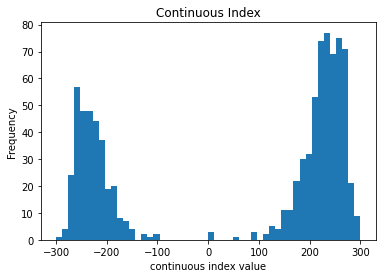

In [7]:
# plot the distribution of the index
plt.figure()
df['cidx'].plot(kind='hist', bins=50, title="Continuous Index")
plt.xlabel('continuous index value')
plt.show()

Average the continuous index between the different subjects

In [11]:
# Convert filename to index
# for fidx, fname in enumerate(df['filename'].unique()):
#     mask_ = df['filename'] == fname
#     df.loc[mask_, 'file_idx'] = fidx

# Average out the cidx
df_avg = df.groupby('filename').agg({'cidx': 'mean'})
df_avg.head()

,cidx
filename,
1_0_2_20161219140525218.jpg.chip.jpg,245.479237
1_0_2_20161219140530307.jpg.chip.jpg,-235.285292
1_0_2_20161219140540938.jpg.chip.jpg,-235.469384
1_0_2_20161219141817185.jpg.chip.jpg,-238.851722
1_0_2_20161219141912009.jpg.chip.jpg,-250.134650


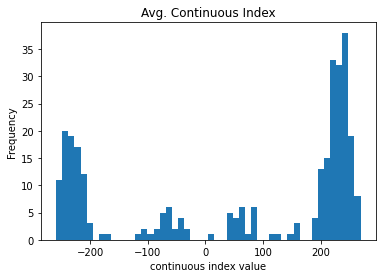

In [13]:
# Plot
plt.figure()
df_avg['cidx'].plot(
    kind='hist', bins=50, 
    title="Avg. Continuous Index", 
    xlabel='s'
)
plt.xlabel('continuous index value')
plt.show()

### Save to csv

In [15]:
# Save the two dataframes as csv files
df.to_csv("processed_data.csv", index=False)
df_avg.to_csv("cidx_avg.csv", index=True)